## Assignment 2


Team: <br>
LASRI Mouad 2021021597 <br>
GEMEDA Metasebia 2020010593

Import the required libraries

In [1]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
import sys
import time
from IPython import display
from mpl_toolkits import mplot3d
from sklearn import datasets

#  Part 1- Three Layer Network 

The activation functions and their derivatives.

In [2]:
def relu(X):
    return np.maximum(X,0)

def relu_derivative(X):
    return 1.0 * (X>0) #.astype(float)

def tanh(X):
    return np.tanh(X)

def tanh_derivative(X):
    return (1.0-tanh(X)**2)

def logistic(X):
    return 1.0/(1.0+np.exp(-X))

def logistic_derivative(X):
    return (logistic(X)*(1.0-logistic(X)))

Now, this is the two-layer neural network that features two input dimensions, one fully-connected hidden layer, and a fully-connected output layer.

In [3]:
# create a two-layer neural network
def create_model(X,hidden_nodes,output_dim=2, activation_function='relu'):
    # this will hold a dictionary of layers
    model = {}
    # save which activation function in the model.
    # the eval() function converts a string into a function
    # this way, we can directly call the appropriate activation function and its derative with just the string name
    # and we can avoid writing "if" statements for each activation function and derivatives
    model['activation_function'] = eval(activation_function);
    
    # set the model activation function derative using eval(), same logic as previous line
    model['activation_function_derivative'] = eval(activation_function + '_derivative')
    
    # input dimensionality
    input_dim = X.shape[1]
    # first set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes)/np.sqrt(input_dim)
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes))
    
    # second set of weights from hidden layer 1 to output
    model['W2'] = np.random.randn(hidden_nodes, output_dim)/np.sqrt(hidden_nodes)
    # set of biases
    model['b2'] = np.zeros((1, output_dim))
    return model

# defines the forward pass given a model and data
def feed_forward(model, x):
    # get weights and biases
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # first layer
    z1 = x.dot(W1) + b1
    
    # activation function
    #a1 = logistic(z1)
    #a1 = tanh(z1)
    a1 = model['activation_function'](z1)
    
    # second layer
    z2 = a1.dot(W2)+b2
    
    # no activation function as this is simply a linear layer!!
    out = z2
    return z1, a1, z2, out

# define the regression loss
def calculate_loss(model,X,y,reg_lambda):
    num_examples = X.shape[0]
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # what are the current predictions
    z1, a1, z2, out = feed_forward(model, X)
    
    # calculate L2 loss
    loss = 0.5*np.sum((out-y)**2)
    
    # add regulatization term to loss
    loss += reg_lambda/2*(np.sum(np.square(W1))+ np.sum(np.square(W2)))
    
    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop(X,y,model,z1,a1,z2,output,reg_lambda):
    
    # derivative of loss function
    delta3 = (output-y)/X.shape[0]
    # multiply this by activation outputs of hidden layer
    dW2 = (a1.T).dot(delta3)
    # and over all neurons
    db2 = np.sum(delta3, axis =0, keepdims=True) #different because it is not being multiplied by all the weights, only 1
    
    # derivative of activation function
    #delta2 = delta3.dot(model['W2'].T)*logistic_derivative(a1) #if logistic
    #delta2 = ... #if tanh
    delta2 = delta3.dot(model['W2'].T)*  model['activation_function_derivative'](a1) #if ReLU
    
    # multiply by input data
    dW1 = (X.T).dot(delta2)
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)
    
    # add regularization terms on the two weights
    dW2 += reg_lambda * model['W2']
    dW1 += reg_lambda * model['W1']
    
    return dW1, dW2, db1, db2

# simple training loop
def train(model, X, y, num_passes=100000, reg_lambda = 0.1, learning_rate = 0.001, tol_thresh=0.001, sgd_status = True):
    # whether to do stochastic gradient descent
    sgd = sgd_status
    
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while done == False:
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False) #bad programming because we dont know the number of  data points needed , 30 is random
            # get predictions
            z1,a1,z2,output = feed_forward(model, X[randinds,:])
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop(X[randinds,:],y[randinds],model,z1,a1,z2,output,reg_lambda)
        else:
            # get predictions
            z1,a1,z2,output = feed_forward(model, X)
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop(X,y,model,z1,a1,z2,output,reg_lambda)
            
        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        
        # do some book-keeping every once in a while
        if i % 1000 == 0:
            loss = calculate_loss(model, X, y, reg_lambda)
            losses.append(loss)
            print("Loss after iteration {}: {}".format(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:
                done = True
            previous_loss = loss
        i += 1
        if i>=num_passes:
            done = True
    return model, losses, i

## Extend the fully-connected two layer perceptron shown in class for the regression problem by one more layer to have two hidden layers.

Now, let's create a three-layer neural network that features two input dimensions, two fully-connected hidden layer, and a fully-connected output layer.

In [4]:
# create a three-layer neural network
def create_3L_model(X,hidden_nodes1, hidden_nodes2, output_dim=2, activation_function='relu'):
    # this will hold a dictionary of layers
    model = {}
    # save which activation function in the model.
    # the eval() function converts a string into a function
    # this way, we can directly call the appropriate activation function and its derative with just the string name
    # and we can avoid writing "if" statements for each activation function and derivatives
    model['activation_function'] = eval(activation_function);
    
    # set the model activation function derative using eval(), same logic as previous line
    model['activation_function_derivative'] = eval(activation_function + '_derivative')
    
    # input dimensionality
    input_dim = X.shape[1]
    # first set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes1)/np.sqrt(input_dim)
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes1))
    
    # second set of weights from hidden layer 1 to hidden layer2
    model['W2'] = np.random.randn(hidden_nodes1, hidden_nodes2)/np.sqrt(hidden_nodes1)
    # set of biases
    model['b2'] = np.zeros((1, hidden_nodes2))
    
    
    # second set of weights from hidden layer 2 to output
    model['W3'] = np.random.randn(hidden_nodes2, output_dim)/np.sqrt(hidden_nodes2)
    # set of biases
    model['b3'] = np.zeros((1, output_dim))
    return model

# defines the forward pass given a model and data
def feed_forward_3L(model, x):
    # get weights and biases
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # first layer
    z1 = x.dot(W1) + b1
    
    # activation function
    #a1 = logistic(z1)
    #a1 = tanh(z1)
    a1 = model['activation_function'](z1)
    
    # second layer
    z2 = a1.dot(W2)+b2
    
    a2 = model['activation_function'](z2)
    
    # third layer
    z3 = a2.dot(W3)+b3
    
    
    
    # no activation function as this is simply a linear layer!!
    out = z3
    return z1, a1, z2, a2, z3, out

# define the regression loss
def calculate_loss_3L(model,X,y,reg_lambda):
    num_examples = X.shape[0]
    W1, b1, W2, b2, W3, b3  = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    # what are the current predictions
    z1, a1, z2, a2, z3, out = feed_forward_3L(model, X)
    
    # calculate L2 loss
    loss = 0.5*np.sum((out-y)**2)
    
    # add regulatization term to loss
    loss += reg_lambda/2*(np.sum(np.square(W1))+ np.sum(np.square(W2))+ np.sum(np.square(W3)))
    
    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop_3L(X,y,model,z1,a1,z2,a2, z3,output,reg_lambda):
     # derivative of loss function
    delta4 = (output-y)/X.shape[0]
    # multiply this by activation outputs of hidden layer
    dW3 = (a2.T).dot(delta4)
    # and over all neurons
    db3 = np.sum(delta4, axis =0, keepdims=True) #different because it is not being multiplied by all the weights, only 1
    
    
    # derivative of activation function
    delta3 = delta4.dot(model['W3'].T)*  model['activation_function_derivative'](a2) #if ReLU
    # multiply by input data
    dW2 = (a1.T).dot(delta3)
    # and sum over all neurons
    db2 = np.sum(delta3, axis=0)
    
    # derivative of activation function
    #delta2 = delta3.dot(model['W2'].T)*logistic_derivative(a1) #if logistic
    #delta2 = ... #if tanh
    delta2 = delta3.dot(model['W2'].T)*  model['activation_function_derivative'](a1) #if ReLU
    
    # multiply by input data
    dW1 = (X.T).dot(delta2)
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)
    
    # add regularization terms on the two weights
    dW3 += reg_lambda * model['W3']
    dW2 += reg_lambda * model['W2']
    dW1 += reg_lambda * model['W1']
    
    return dW1, dW2,dW3, db1, db2, db3
    
    
# simple training loop
def train_3L(model, X, y, num_passes=100000, reg_lambda = 0.1, learning_rate = 0.001, tol_thresh=0.001, sgd_status = True ):
    # whether to do stochastic gradient descent
    sgd = sgd_status
    
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while done == False:
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False) #bad programming because we dont know the number of  data points needed , 30 is random
            # get predictions
            z1,a1,z2, a2, z3, output = feed_forward_3L(model, X[randinds,:])
            # feed this into backprop
            dW1, dW2, dW3, db1, db2, db3 = backprop_3L(X[randinds,:],y[randinds],model,z1,a1,z2,a2, z3, output,reg_lambda)
        else:
            # get predictions
            z1,a1,z2, a2, z3, output = feed_forward_3L(model, X)
            # feed this into backprop
            dW1, dW2, dW3, db1, db2, db3 = backprop_3L(X,y,model,z1,a1,z2,a2, z3, output,reg_lambda)
            
        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        model['W3'] -= learning_rate * dW3
        model['b3'] -= learning_rate * db3
        
        
        # do some book-keeping every once in a while
        if i % 1000 == 0:
            loss = calculate_loss_3L(model, X, y, reg_lambda)
            losses.append(loss)
            print("Loss after iteration {}: {}".format(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:
                done = True
            previous_loss = loss
        i += 1
        if i>=num_passes:
            done = True
    return model, losses, i

## Series of tests

In [5]:
#comparing 2 layer NN with 3 layer one 

numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

# training set size
num_examples = len(X) 
# input layer dimensionality
nn_input_dim = 2 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
#tolerance threshold
tol_thresh = 0.0001
#maximum iteration
num_passes =100000
#SGD status
sgd_status = False   # --> NO SGD
# regularization strength
reg_lambda = 0   #--> No regularization


TEST1

In [6]:
#--> TEST1

Loss_collection =[]
iterations_colection = np.zeros([10])
outputs_collection=[]
# create the models


#running the network 10 times
for i in range(10):
    model1 = create_model(X,8,output_dim=1) #take 8 neurons for the two-layer version
    #train it
    model1, losses1, iterations_colection[i] = train(model1,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)
    # determine predictions of the trained models
    
    Loss_collection.append(losses1)
    # determine predictions of the trained models
    outputs_collection.append(feed_forward(model1, X))


#model1, losses1 = train(model1,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)

Loss after iteration 0: 1573.655131482419
Loss after iteration 1000: 24.900162806702642


C:\Users\Meti\AppData\Local\Temp\ipykernel_7252\3503835815.py:129: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 2000: 9.961601632553188
Loss after iteration 3000: 7.790656716581123
Loss after iteration 4000: 7.221747804964129
Loss after iteration 5000: 6.511874239805082
Loss after iteration 6000: 5.915394179609502
Loss after iteration 7000: 5.374589609438653
Loss after iteration 8000: 5.152333849316284
Loss after iteration 9000: 5.019031342601189
Loss after iteration 10000: 4.877876367953332
Loss after iteration 11000: 4.6125454312841345
Loss after iteration 12000: 4.501876628128797
Loss after iteration 13000: 4.42285448326579
Loss after iteration 14000: 4.357947757334233
Loss after iteration 15000: 4.285731355347536
Loss after iteration 16000: 4.226614252754905
Loss after iteration 17000: 4.175605755298217
Loss after iteration 18000: 4.1296561257047575
Loss after iteration 19000: 4.088007751155996
Loss after iteration 20000: 4.050156578581653
Loss after iteration 21000: 4.0061134630822135
Loss after iteration 22000: 3.97190348037527
Loss after iteration 23000: 3.94239585399

Loss after iteration 38000: 5.472478355756992
Loss after iteration 39000: 5.45587185771693
Loss after iteration 40000: 5.439653438121416
Loss after iteration 41000: 5.423619635451531
Loss after iteration 42000: 5.40756045261482
Loss after iteration 43000: 5.391908577073619
Loss after iteration 44000: 5.376947563463299
Loss after iteration 45000: 5.362416118871763
Loss after iteration 46000: 5.347816013228924
Loss after iteration 47000: 5.334417597149996
Loss after iteration 48000: 5.322066295147814
Loss after iteration 49000: 5.310892376304459
Loss after iteration 50000: 5.299991730771597
Loss after iteration 51000: 5.289879873304821
Loss after iteration 52000: 5.279985718101594
Loss after iteration 53000: 5.27133815426209
Loss after iteration 54000: 5.262182273626845
Loss after iteration 55000: 5.253771037379961
Loss after iteration 56000: 5.245974373281641
Loss after iteration 57000: 5.238201573808541
Loss after iteration 58000: 5.2308305588776065
Loss after iteration 59000: 5.223712

Loss after iteration 36000: 3.7857774612756803
Loss after iteration 37000: 3.7507939828798555
Loss after iteration 38000: 3.7227440238416967
Loss after iteration 39000: 3.6864166415569
Loss after iteration 40000: 3.659230241356117
Loss after iteration 41000: 3.638168143306483
Loss after iteration 42000: 3.618037636970018
Loss after iteration 43000: 3.5952371154033576
Loss after iteration 44000: 3.5710267114256524
Loss after iteration 45000: 3.551332458096296
Loss after iteration 46000: 3.533618967415268
Loss after iteration 47000: 3.517526819233869
Loss after iteration 48000: 3.5028618332085433
Loss after iteration 49000: 3.4894553306593754
Loss after iteration 50000: 3.477064085090052
Loss after iteration 51000: 3.4659959436568806
Loss after iteration 52000: 3.4559650206001242
Loss after iteration 53000: 3.4466734833955615
Loss after iteration 54000: 3.437599950465973
Loss after iteration 55000: 3.429294688997731
Loss after iteration 56000: 3.4207584652045644
Loss after iteration 5700

Loss after iteration 12000: 4.675902498277976
Loss after iteration 13000: 4.597997669793221
Loss after iteration 14000: 4.523439136403073
Loss after iteration 15000: 4.463011353846
Loss after iteration 16000: 4.403798216426306
Loss after iteration 17000: 4.356020997663092
Loss after iteration 18000: 4.317390161777168
Loss after iteration 19000: 4.285428068502476
Loss after iteration 20000: 4.250317478852198
Loss after iteration 21000: 4.2161513144652805
Loss after iteration 22000: 4.188616770388115
Loss after iteration 23000: 4.161183993010791
Loss after iteration 24000: 3.8305932110960796
Loss after iteration 25000: 3.673133548979998
Loss after iteration 26000: 3.619771452569606
Loss after iteration 27000: 3.591601911931277
Loss after iteration 28000: 3.5690608302367663
Loss after iteration 29000: 3.5496069551740614
Loss after iteration 30000: 3.529824391365026
Loss after iteration 31000: 3.5036101192091578
Loss after iteration 32000: 3.4658153073977025
Loss after iteration 33000: 3.4

Loss after iteration 98000: 2.2821583888727823
Loss after iteration 99000: 2.2807606189708522
Loss after iteration 0: 1395.1628430816183
Loss after iteration 1000: 24.182939191939738
Loss after iteration 2000: 9.539317461901819
Loss after iteration 3000: 7.521397283572733
Loss after iteration 4000: 6.603562461795529
Loss after iteration 5000: 5.662447294978164
Loss after iteration 6000: 4.482089452433605
Loss after iteration 7000: 3.584773991846426
Loss after iteration 8000: 3.251276348582203
Loss after iteration 9000: 3.1217553905235196
Loss after iteration 10000: 2.362546443754159
Loss after iteration 11000: 2.023501724441206
Loss after iteration 12000: 1.9491902263340644
Loss after iteration 13000: 1.916195799351033
Loss after iteration 14000: 1.8930056507131383
Loss after iteration 15000: 1.8781769310513117
Loss after iteration 16000: 1.8686060377331675
Loss after iteration 17000: 1.8587180027749546
Loss after iteration 18000: 1.8523638755477765
Loss after iteration 19000: 1.848333

--> TEST1(Continued for 3L)

In [7]:
# create the 3 layer model

Loss_collection2 =[]
iterations_colection2 = np.zeros([10])
outputs_collection2=[]
# create the models


#running the network 10 times
for i in range(10):
    model2 = create_3L_model(X,4,4 ,output_dim=1) #take 4+4 neurons for the three-layer version
    #train it
    model2, losses2, iterations_colection2[i] = train_3L(model2,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)
    # determine predictions of the trained models
    
    Loss_collection2.append(losses2)
    # determine predictions of the trained models
    outputs_collection2.append(feed_forward_3L(model2, X))




Loss after iteration 0: 1764.4575850621425
Loss after iteration 1000: 286.9132976085286


C:\Users\Meti\AppData\Local\Temp\ipykernel_7252\1279318385.py:154: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 2000: 279.0072517933188
Loss after iteration 3000: 277.7012167341469
Loss after iteration 4000: 277.5691136681373
Loss after iteration 5000: 277.5691129189283
Loss after iteration 0: 1805.2152079778264
Loss after iteration 1000: 29.295297745123293
Loss after iteration 2000: 27.39284490977726
Loss after iteration 3000: 24.567437288410964
Loss after iteration 4000: 22.801129882034378
Loss after iteration 5000: 21.013094898435497
Loss after iteration 6000: 19.982382118975337
Loss after iteration 7000: 20.096489155190024
Loss after iteration 8000: 20.75591870708442
Loss after iteration 9000: 19.523971668848947
Loss after iteration 10000: 18.544392085321256
Loss after iteration 11000: 18.515117789032228
Loss after iteration 12000: 17.687788591122732
Loss after iteration 13000: 17.142513242682853
Loss after iteration 14000: 17.243223956348135
Loss after iteration 15000: 15.08864410035573
Loss after iteration 16000: 16.279815866876397
Loss after iteration 17000: 15.933511

Loss after iteration 52000: 6.319992639199381
Loss after iteration 53000: 5.917922521016164
Loss after iteration 54000: 5.77929177468017
Loss after iteration 55000: 6.5182529764415245
Loss after iteration 56000: 5.391174134197057
Loss after iteration 57000: 5.169746264178445
Loss after iteration 58000: 5.696848464614045
Loss after iteration 59000: 5.646665015155169
Loss after iteration 60000: 5.578403689274542
Loss after iteration 61000: 5.49630164766625
Loss after iteration 62000: 5.399813680115663
Loss after iteration 63000: 5.036004301664206
Loss after iteration 64000: 4.911841481997969
Loss after iteration 65000: 5.319372833301113
Loss after iteration 66000: 6.281042823586575
Loss after iteration 67000: 4.737059144793562
Loss after iteration 68000: 4.768506522965039
Loss after iteration 69000: 4.933666834728097
Loss after iteration 70000: 6.50596912056547
Loss after iteration 71000: 5.863780135651195
Loss after iteration 72000: 5.56678830797032
Loss after iteration 73000: 6.0300251

Loss after iteration 54000: 6.803306715161356
Loss after iteration 55000: 6.608695603293263
Loss after iteration 56000: 6.3038837521165325
Loss after iteration 57000: 6.443188298288523
Loss after iteration 58000: 7.020260937327462
Loss after iteration 59000: 6.858101804022568
Loss after iteration 60000: 6.439328564595694
Loss after iteration 61000: 6.6976612021673425
Loss after iteration 62000: 6.500111818014376
Loss after iteration 63000: 6.516055908975677
Loss after iteration 64000: 6.584702854789171
Loss after iteration 65000: 6.692536156838485
Loss after iteration 66000: 6.606466393793306
Loss after iteration 67000: 6.56129142267782
Loss after iteration 68000: 6.522213078165309
Loss after iteration 69000: 6.488200701678258
Loss after iteration 70000: 6.457937381677064
Loss after iteration 71000: 6.431530588075049
Loss after iteration 72000: 6.406590458891876
Loss after iteration 73000: 6.383936612717542
Loss after iteration 74000: 6.363358764602667
Loss after iteration 75000: 6.343

Loss after iteration 31000: 7.569200667442728
Loss after iteration 32000: 7.235731719507304
Loss after iteration 33000: 7.309514360415156
Loss after iteration 34000: 7.956592614579369
Loss after iteration 35000: 7.538597047657953
Loss after iteration 36000: 7.484719427504312
Loss after iteration 37000: 7.408022569253582
Loss after iteration 38000: 7.396648679279853
Loss after iteration 39000: 7.34601546340061
Loss after iteration 40000: 7.306606917998124
Loss after iteration 41000: 7.271016686349287
Loss after iteration 42000: 7.202913718797837
Loss after iteration 43000: 7.079690360929253
Loss after iteration 44000: 6.893436489931202
Loss after iteration 45000: 7.154743217945525
Loss after iteration 46000: 6.897101102689594
Loss after iteration 47000: 12.155452106886237
Loss after iteration 48000: 6.762129404157839
Loss after iteration 49000: 6.724332437537876
Loss after iteration 50000: 8.776691537065206
Loss after iteration 51000: 6.705039672022261
Loss after iteration 52000: 6.7121

Loss after iteration 38000: 6.967394561145716
Loss after iteration 39000: 6.950434040590104
Loss after iteration 40000: 6.878815418244844
Loss after iteration 41000: 6.838382550283968
Loss after iteration 42000: 6.700229227385301
Loss after iteration 43000: 7.0325307300243365
Loss after iteration 44000: 6.724355089565306
Loss after iteration 45000: 7.001643293918882
Loss after iteration 46000: 6.532342130725495
Loss after iteration 47000: 8.822369398921891
Loss after iteration 48000: 6.403858079103955
Loss after iteration 49000: 6.666923707833822
Loss after iteration 50000: 6.417470411786289
Loss after iteration 51000: 6.650061371777119
Loss after iteration 52000: 7.429948577449044
Loss after iteration 53000: 6.2025160583211205
Loss after iteration 54000: 6.960312250261629
Loss after iteration 55000: 7.2532231078676155
Loss after iteration 56000: 7.036598651583459
Loss after iteration 57000: 6.284792805299274
Loss after iteration 58000: 6.289321401218858
Loss after iteration 59000: 6.1

Comparison of the 2 layer NN with the 2 layer one with 10 runs each

LOSS COMPARISON

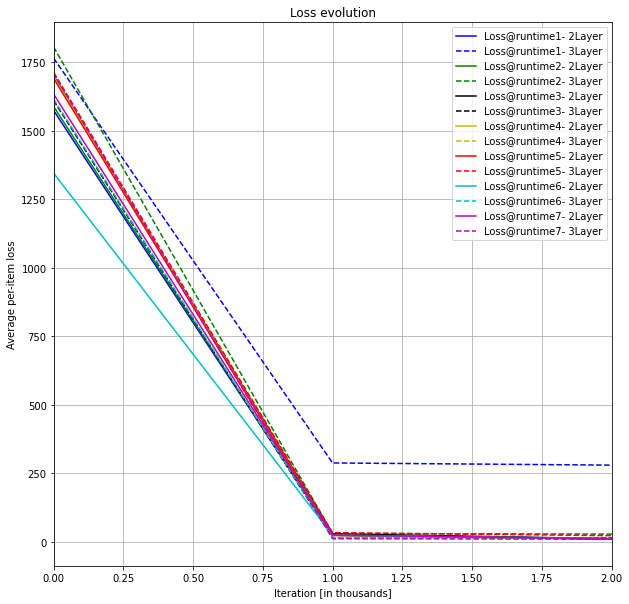

In [8]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot( Loss_collection[0], 'b',Loss_collection2[0], 'b--', Loss_collection[1], 'g',Loss_collection2[1], 'g--', Loss_collection[2], 'k',Loss_collection2[2], 'k--', Loss_collection[3], 'y',Loss_collection2[3], 'y--', Loss_collection[4], 'r',Loss_collection2[4], 'r--', Loss_collection[5], 'c',Loss_collection2[5], 'c--', Loss_collection[6], 'm',Loss_collection2[6], 'm--')

#plt.plot(Loss_collection2[0], 'g-')
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.legend(['Loss@runtime1- 2Layer', 'Loss@runtime1- 3Layer', 'Loss@runtime2- 2Layer', 'Loss@runtime2- 3Layer', 'Loss@runtime3- 2Layer', 'Loss@runtime3- 3Layer', 'Loss@runtime4- 2Layer', 'Loss@runtime4- 3Layer', 'Loss@runtime5- 2Layer', 'Loss@runtime5- 3Layer', 'Loss@runtime6- 2Layer', 'Loss@runtime6- 3Layer', 'Loss@runtime7- 2Layer', 'Loss@runtime7- 3Layer'])
plt.xlim([0, 2])
plt.grid()
plt.show()

The losses have various initial points as well as end points as stochastic gradient descent is removed and there is random weight initialization. The next figure will try to observe the loss curve over the many iterations

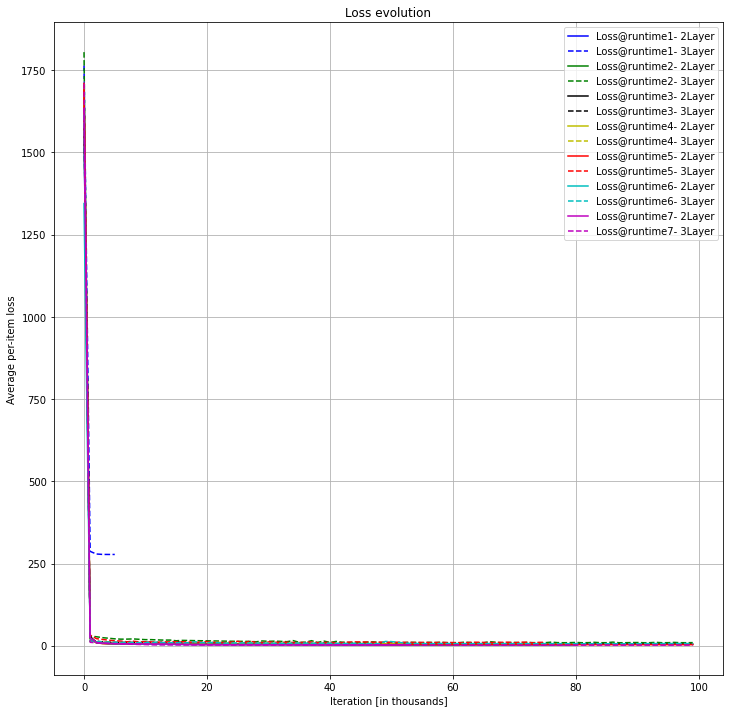

In [9]:
%matplotlib inline
plt.figure(figsize=(12,12))
plt.plot( Loss_collection[0], 'b',Loss_collection2[0], 'b--', Loss_collection[1], 'g',Loss_collection2[1], 'g--', Loss_collection[2], 'k',Loss_collection2[2], 'k--', Loss_collection[3], 'y',Loss_collection2[3], 'y--', Loss_collection[4], 'r',Loss_collection2[4], 'r--', Loss_collection[5], 'c',Loss_collection2[5], 'c--', Loss_collection[6], 'm',Loss_collection2[6], 'm--')

#plt.plot(Loss_collection2[0], 'g-')
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.legend(['Loss@runtime1- 2Layer', 'Loss@runtime1- 3Layer', 'Loss@runtime2- 2Layer', 'Loss@runtime2- 3Layer', 'Loss@runtime3- 2Layer', 'Loss@runtime3- 3Layer', 'Loss@runtime4- 2Layer', 'Loss@runtime4- 3Layer', 'Loss@runtime5- 2Layer', 'Loss@runtime5- 3Layer', 'Loss@runtime6- 2Layer', 'Loss@runtime6- 3Layer', 'Loss@runtime7- 2Layer', 'Loss@runtime7- 3Layer'])
plt.grid()
plt.show()

Iteration comparison

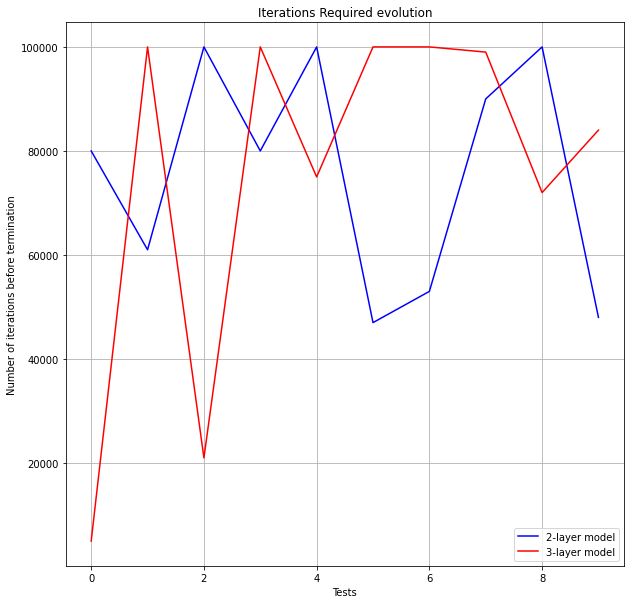

In [10]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot( iterations_colection, 'b',iterations_colection2, 'r')
plt.xlabel('Tests')
plt.ylabel('Number of iterations before termination')
plt.title('Iterations Required evolution')
plt.legend(['2-layer model' , '3-layer model'])
plt.grid()
plt.show()

Here we can observe that the number of iterations required is not the same for each run as SGD and regularizations are removed

Test 2

In [11]:
Loss_collection =[]
iterations_colection = np.zeros([10])
outputs_collection=[]
# create the model and running 10 times for a hidden layer with 16 neurons


#running the network 10 times
for i in range(10):
    model1 = create_model(X,16,output_dim=1) #take 8 neurons for the two-layer version
    #train it
    model1, losses1, iterations_colection[i] = train(model1,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)
    # determine predictions of the trained models
    
    Loss_collection.append(losses1)
    # determine predictions of the trained models
    outputs_collection.append(feed_forward(model1, X))

Loss after iteration 0: 1266.9333858232485
Loss after iteration 1000: 24.711493288438813


C:\Users\Meti\AppData\Local\Temp\ipykernel_7252\3503835815.py:129: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 2000: 9.405016245818471
Loss after iteration 3000: 6.614808973313058
Loss after iteration 4000: 5.227332821853244
Loss after iteration 5000: 4.276958928932766
Loss after iteration 6000: 3.5051638839753387
Loss after iteration 7000: 3.2249243712590885
Loss after iteration 8000: 2.72779506065315
Loss after iteration 9000: 2.346415265713487
Loss after iteration 10000: 1.7631847194416266
Loss after iteration 11000: 1.4095955532287932
Loss after iteration 12000: 1.3508566622345706
Loss after iteration 13000: 1.3186819409617139
Loss after iteration 14000: 1.2966466799403744
Loss after iteration 15000: 1.280820267126193
Loss after iteration 16000: 1.2708419644062416
Loss after iteration 17000: 1.262776286254122
Loss after iteration 18000: 1.2481015277234777
Loss after iteration 19000: 1.2377382203528906
Loss after iteration 20000: 1.2263007752095878
Loss after iteration 21000: 1.219035857677005
Loss after iteration 22000: 1.2109055081504243
Loss after iteration 23000: 1.2

Loss after iteration 77000: 0.20315947664845446
Loss after iteration 78000: 0.20226288732639225
Loss after iteration 79000: 0.2014843731878955
Loss after iteration 80000: 0.20079103144646412
Loss after iteration 81000: 0.20016926896973872
Loss after iteration 82000: 0.19956605102364977
Loss after iteration 83000: 0.19880738211412782
Loss after iteration 84000: 0.19824833764133043
Loss after iteration 85000: 0.19770295638745217
Loss after iteration 86000: 0.19722909371182248
Loss after iteration 87000: 0.1967618172586441
Loss after iteration 88000: 0.19604453040054645
Loss after iteration 89000: 0.19554697717830913
Loss after iteration 90000: 0.19508676366623845
Loss after iteration 91000: 0.19468116645591557
Loss after iteration 92000: 0.1943186750423955
Loss after iteration 93000: 0.19394984226718867
Loss after iteration 94000: 0.19327696686645465
Loss after iteration 95000: 0.192759343584858
Loss after iteration 96000: 0.19244131184124064
Loss after iteration 97000: 0.192103006920556

Loss after iteration 54000: 0.917454389105789
Loss after iteration 55000: 0.9156249526218588
Loss after iteration 56000: 0.9138399945356032
Loss after iteration 57000: 0.9120860496910556
Loss after iteration 58000: 0.9103867976304983
Loss after iteration 59000: 0.9084446727017605
Loss after iteration 60000: 0.9067631721254125
Loss after iteration 61000: 0.9051313067763158
Loss after iteration 62000: 0.9035395383114901
Loss after iteration 63000: 0.9019812924923495
Loss after iteration 64000: 0.900461287113103
Loss after iteration 65000: 0.8989708067622618
Loss after iteration 66000: 0.8975232718518146
Loss after iteration 67000: 0.8961068042649036
Loss after iteration 68000: 0.8947146327626577
Loss after iteration 69000: 0.8933613926637926
Loss after iteration 70000: 0.892040338520396
Loss after iteration 71000: 0.8907455576008213
Loss after iteration 72000: 0.8894810954036841
Loss after iteration 73000: 0.8882549191884732
Loss after iteration 74000: 0.8870483980874897
Loss after itera

Loss after iteration 30000: 0.4435314091991647
Loss after iteration 31000: 0.4375454229691014
Loss after iteration 32000: 0.4329397729331967
Loss after iteration 33000: 0.4292023259302206
Loss after iteration 34000: 0.42601732469968623
Loss after iteration 35000: 0.42315737071503584
Loss after iteration 36000: 0.42079106624964313
Loss after iteration 37000: 0.41759897299144283
Loss after iteration 38000: 0.4147484159212612
Loss after iteration 39000: 0.412603918946537
Loss after iteration 40000: 0.41087053653158384
Loss after iteration 41000: 0.4093748735382748
Loss after iteration 42000: 0.40801703174913695
Loss after iteration 43000: 0.4064956096890073
Loss after iteration 44000: 0.4044543086861213
Loss after iteration 45000: 0.40295225521984146
Loss after iteration 46000: 0.4016285114737775
Loss after iteration 47000: 0.4004475974476781
Loss after iteration 48000: 0.39938745603530934
Loss after iteration 49000: 0.3983213172375237
Loss after iteration 50000: 0.39737211946805395
Loss 

Loss after iteration 24000: 1.3089497643873678
Loss after iteration 25000: 1.2990833447390082
Loss after iteration 26000: 1.284001137580084
Loss after iteration 27000: 1.2746343289286486
Loss after iteration 28000: 1.26805536202302
Loss after iteration 29000: 1.2606634498928897
Loss after iteration 30000: 1.2524579517055034
Loss after iteration 31000: 1.2467493787654156
Loss after iteration 32000: 1.2425354496130734
Loss after iteration 33000: 1.2389361201113966
Loss after iteration 34000: 1.235759140066356
Loss after iteration 35000: 1.2319398839784717
Loss after iteration 36000: 1.228983482683027
Loss after iteration 37000: 1.2263698025084713
Loss after iteration 38000: 1.2240268537527292
Loss after iteration 39000: 1.2219672909559434
Loss after iteration 40000: 1.2200869473843643
Loss after iteration 41000: 1.218354841472402
Loss after iteration 42000: 1.2167617191459579
Loss after iteration 43000: 1.2151374223207922
Loss after iteration 44000: 1.213656828070815
Loss after iteration

Loss after iteration 1000: 23.339846928659398
Loss after iteration 2000: 8.92079156550373
Loss after iteration 3000: 6.139305902952286
Loss after iteration 4000: 4.4493410610308075
Loss after iteration 5000: 3.4083079483428538
Loss after iteration 6000: 2.7595219219815026
Loss after iteration 7000: 2.277447420857308
Loss after iteration 8000: 1.6078547544920523
Loss after iteration 9000: 1.3024138677196218
Loss after iteration 10000: 1.0444210081645302
Loss after iteration 11000: 0.8571733834917677
Loss after iteration 12000: 0.7220396602220039
Loss after iteration 13000: 0.6450640796120845
Loss after iteration 14000: 0.5848325865212827
Loss after iteration 15000: 0.5359371784088105
Loss after iteration 16000: 0.5076859606690657
Loss after iteration 17000: 0.49325225968797126
Loss after iteration 18000: 0.4805497978227772
Loss after iteration 19000: 0.4719243709638735
Loss after iteration 20000: 0.4653550533844849
Loss after iteration 21000: 0.4600121234394998
Loss after iteration 2200

--> TEST2(Continued for 3L)

In [12]:
# creating the 3 layer model and running 10 times for 8+8 neurons

Loss_collection2 =[]
iterations_colection2 = np.zeros([10])
outputs_collection2=[]
# create the models


#running the network 10 times
for i in range(10):
    model2 = create_3L_model(X,8,8 ,output_dim=1) #take 4+4 neurons for the three-layer version
    #train it
    model2, losses2, iterations_colection2[i] = train_3L(model2,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)
    # determine predictions of the trained models
    
    Loss_collection2.append(losses2)
    # determine predictions of the trained models
    outputs_collection2.append(feed_forward_3L(model2, X))

Loss after iteration 0: 1675.9084003765352


C:\Users\Meti\AppData\Local\Temp\ipykernel_7252\1279318385.py:154: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 1000: 12.154309167581923
Loss after iteration 2000: 13.944734730201956
Loss after iteration 3000: 11.452925213049335
Loss after iteration 4000: 6.76147722948926
Loss after iteration 5000: 5.353396261037253
Loss after iteration 6000: 4.465168630649412
Loss after iteration 7000: 2.336095518450724
Loss after iteration 8000: 4.978308128298147
Loss after iteration 9000: 4.011743233281165
Loss after iteration 10000: 2.1639875718669592
Loss after iteration 11000: 2.311392846451939
Loss after iteration 12000: 2.464510764083503
Loss after iteration 13000: 1.809531200583027
Loss after iteration 14000: 1.7457082724122848
Loss after iteration 15000: 1.830365382697427
Loss after iteration 16000: 1.6775927121062353
Loss after iteration 17000: 1.5971200678258286
Loss after iteration 18000: 1.7210412692762682
Loss after iteration 19000: 1.6122552024409837
Loss after iteration 20000: 1.5497859631729585
Loss after iteration 21000: 1.4829627940106644
Loss after iteration 22000: 1.424

Loss after iteration 86000: 0.8413120090892621
Loss after iteration 87000: 0.8352432357604669
Loss after iteration 88000: 0.8660370811780864
Loss after iteration 89000: 0.8280504529064717
Loss after iteration 90000: 0.7920335477173545
Loss after iteration 91000: 0.7958830020745333
Loss after iteration 92000: 0.8406366191385993
Loss after iteration 93000: 0.8361267494262999
Loss after iteration 94000: 0.8145667125569718
Loss after iteration 95000: 0.8049006378062353
Loss after iteration 96000: 0.7952781726133824
Loss after iteration 97000: 0.7944806448516896
Loss after iteration 98000: 0.7917360034699978
Loss after iteration 99000: 0.7858145182520971
Loss after iteration 0: 1534.8086033089082
Loss after iteration 1000: 14.510291564756848
Loss after iteration 2000: 8.54803684040269
Loss after iteration 3000: 6.605087213702971
Loss after iteration 4000: 4.506725099449494
Loss after iteration 5000: 3.443997705129791
Loss after iteration 6000: 2.4308891514499473
Loss after iteration 7000: 2

Loss after iteration 61000: 0.5341600491289731
Loss after iteration 62000: 0.5195000711745239
Loss after iteration 63000: 0.53151044753905
Loss after iteration 64000: 0.5371836496845069
Loss after iteration 65000: 0.5331135797554222
Loss after iteration 66000: 0.5312826463483045
Loss after iteration 67000: 0.5273927481030826
Loss after iteration 68000: 0.523763968738365
Loss after iteration 69000: 0.5205461388127486
Loss after iteration 70000: 0.5181740791533456
Loss after iteration 71000: 0.5151648311700231
Loss after iteration 72000: 0.5124645322197524
Loss after iteration 73000: 0.5099418523176633
Loss after iteration 74000: 0.5077086115681066
Loss after iteration 75000: 0.5058901085494709
Loss after iteration 76000: 0.503696032672867
Loss after iteration 77000: 0.5020085924982286
Loss after iteration 78000: 0.5005420278642276
Loss after iteration 79000: 0.4990814347772965
Loss after iteration 80000: 0.49759935100043107
Loss after iteration 81000: 0.495545636144177
Loss after iterat

Loss after iteration 40000: 0.52116749271014
Loss after iteration 41000: 0.5188011578117819
Loss after iteration 42000: 0.515881045426942
Loss after iteration 43000: 0.5130747521120983
Loss after iteration 44000: 0.5111685788732458
Loss after iteration 45000: 0.5096344378886667
Loss after iteration 46000: 0.5083712366361711
Loss after iteration 47000: 0.507249456372242
Loss after iteration 48000: 0.5062362896589495
Loss after iteration 49000: 0.5053135569615107
Loss after iteration 50000: 0.5044653929706467
Loss after iteration 51000: 0.5036796837648458
Loss after iteration 52000: 0.5029436209915972
Loss after iteration 53000: 0.5022463449566084
Loss after iteration 54000: 0.5015882149910594
Loss after iteration 55000: 0.500971821157042
Loss after iteration 56000: 0.5005471964199725
Loss after iteration 57000: 0.5013033608841779
Loss after iteration 58000: 0.5111922576652068
Loss after iteration 59000: 0.5065330431535695
Loss after iteration 60000: 0.5045457108082256
Loss after iterati

Loss after iteration 54000: 0.8650356465195108
Loss after iteration 55000: 0.6377197690825304
Loss after iteration 56000: 0.7014805481164065
Loss after iteration 57000: 0.5679096596422648
Loss after iteration 58000: 0.8743218368927381
Loss after iteration 59000: 0.5167151641382959
Loss after iteration 60000: 1.2352051993017006
Loss after iteration 61000: 0.5067761788041425
Loss after iteration 62000: 0.4662320539291764
Loss after iteration 63000: 0.5204057124138975
Loss after iteration 64000: 0.6001340841321966
Loss after iteration 65000: 0.5500197264357563
Loss after iteration 66000: 0.5789498993618023
Loss after iteration 67000: 0.7344503344541916
Loss after iteration 68000: 0.4633909716581392
Loss after iteration 69000: 0.5254136143986746
Loss after iteration 70000: 0.6001084098126691
Loss after iteration 71000: 0.7992767509590886
Loss after iteration 72000: 0.973739521547801
Loss after iteration 73000: 0.691584409412992
Loss after iteration 74000: 0.5372372815541332
Loss after iter

Loss after iteration 30000: 0.6978765721080746
Loss after iteration 31000: 0.7472201334410161
Loss after iteration 32000: 0.7172540895618518
Loss after iteration 33000: 1.0309894513330786
Loss after iteration 34000: 0.5707008974346162
Loss after iteration 35000: 0.8427991103452048
Loss after iteration 36000: 0.7171094259206503
Loss after iteration 37000: 0.658158861337282
Loss after iteration 38000: 0.7092760783380926
Loss after iteration 39000: 0.7194516374343455
Loss after iteration 40000: 0.6952281659243138
Loss after iteration 41000: 0.6921158517157535
Loss after iteration 42000: 0.6843599589535964
Loss after iteration 43000: 0.6789577151370508
Loss after iteration 44000: 0.6718540140099326
Loss after iteration 45000: 0.6662243709847535
Loss after iteration 46000: 0.6611078994144437
Loss after iteration 47000: 0.6566078994151902
Loss after iteration 48000: 0.650624218097868
Loss after iteration 49000: 0.6066874883348012
Loss after iteration 50000: 0.6363900286954501
Loss after iter

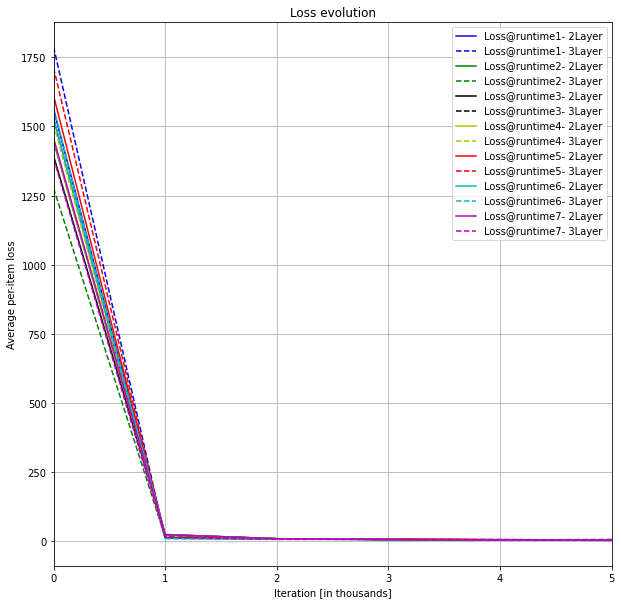

In [15]:

plt.figure(figsize=(10,10))
plt.plot( Loss_collection[0], 'b',Loss_collection2[0], 'b--', Loss_collection[1], 'g',Loss_collection2[1], 'g--', Loss_collection[2], 'k',Loss_collection2[2], 'k--', Loss_collection[3], 'y',Loss_collection2[3], 'y--', Loss_collection[4], 'r',Loss_collection2[4], 'r--', Loss_collection[5], 'c',Loss_collection2[5], 'c--', Loss_collection[6], 'm',Loss_collection2[6], 'm--')

#plt.plot(Loss_collection2[0], 'g-')
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.legend(['Loss@runtime1- 2Layer', 'Loss@runtime1- 3Layer', 'Loss@runtime2- 2Layer', 'Loss@runtime2- 3Layer', 'Loss@runtime3- 2Layer', 'Loss@runtime3- 3Layer', 'Loss@runtime4- 2Layer', 'Loss@runtime4- 3Layer', 'Loss@runtime5- 2Layer', 'Loss@runtime5- 3Layer', 'Loss@runtime6- 2Layer', 'Loss@runtime6- 3Layer', 'Loss@runtime7- 2Layer', 'Loss@runtime7- 3Layer'])
plt.xlim([0, 5])
plt.grid()
plt.show()

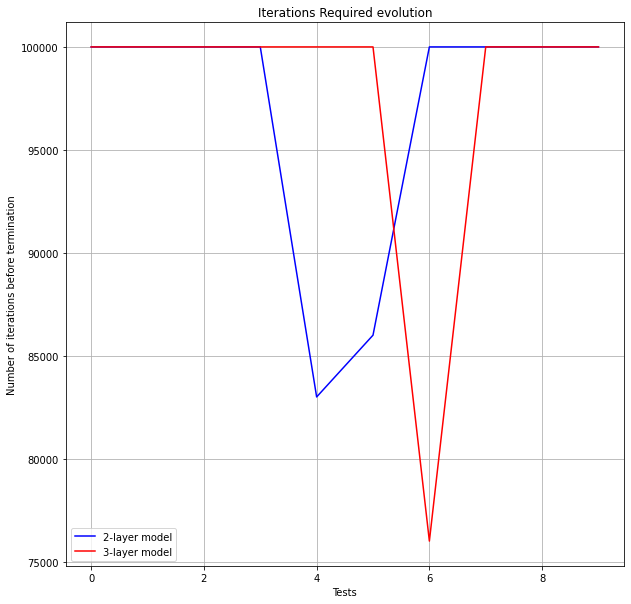

In [16]:

plt.figure(figsize=(10,10))
plt.plot( iterations_colection, 'b',iterations_colection2, 'r')
plt.xlabel('Tests')
plt.ylabel('Number of iterations before termination')
plt.title('Iterations Required evolution')
plt.legend(['2-layer model' , '3-layer model'])
plt.grid()
plt.show()

As the number of neurons increase, we can see that training till maximum iteration becomes more common

Bonus: arbitrary number of layers

Change the functions such that they can accept an arbitrary number of layers, but
keeping the overall call-logic and training loops the same 

In [15]:
# create a three-layer neural network
def create_model_new(X,nodes_for_layer, L, activation_function='relu'):
    # where nodes_for_layer is the  array(or list) the dimentsions of each layer
    # where L is the number of hidden layers assigned + 2 (input and output dimensions)
    
    # this will hold a dictionary of layers
    model = {}   

    model['activation_function'] = eval(activation_function);
    
    # set the model activation function derative using eval(), same logic as previous line
    model['activation_function_derivative'] = eval(activation_function + '_derivative')
    
    for j in range(1, L): 
        model['W' + str(j)] = np.random.randn(nodes_for_layer[j], nodes_for_layer[j - 1])/ np.sqrt(nodes_for_layer[j])
        model['b' + str(j)] = np.zeros((1, nodes_for_layer[j]))

    return model

In [ ]:
# defines the forward pass given a model and data
def feed_forward_new(model, x, L):
    # get weights and biases
    W= np.array([L])
    for j in range(L):
        W[j] = model['W' + str(j+1)]
        b[j] = model['b' + str(j+1)]
     
  
    # assuming vectorization or broadcasting
    A = x # here A is activations from previous layer (or input data)
    hid_lay = len(L)//2
    
    for l in range (1, L):
        A_previous = A
        Z = np.dot(W, A_previous) + b
        A = model['activation_function'](Z)
    
    
    Z= np.dot(W, A) + b
    out = Z
    
    return Z,A, out

In [ ]:

def calculate_loss_new(model,X,y,reg_lambda, L):
    num_examples = X.shape[0]
    W= np.array([L])
    for j in range(L):
        W[j] = model['W' + str(j+1)]
        b[j] = model['b' + str(j+1)]
        
        
    # what are the current predictions
    Z, A, out = feed_forward_new(model, X, L)
    
    # calculate L2 loss
    loss = 0.5*np.sum((out-y)**2)
    
    # add regulatization term to loss
    loss += reg_lambda/2*(np.sum(np.square(W1))+ np.sum(np.square(W2))+ np.sum(np.square(W3)))
    
    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network


In [ ]:
def backprop_new
    



In [ ]:
def train_new

## Part2 Pytorch version

Adapt the code from class to solve the exact same regression problem with three layers and the same number of
parameters. Use the ‘“nn” layers. Visualize the network architecture as well.


In [17]:
import seaborn as sb
import pandas
import torch

In [22]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=torch.linspace(-8,8,numDataOne)
ys=torch.linspace(-8,8,numDataOne)
counter=0
X2=torch.zeros([numData,2])
y2=torch.zeros([numData,1])
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X2[counter,0]=xs[r]
        X2[counter,1] = ys[c]
        y2[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

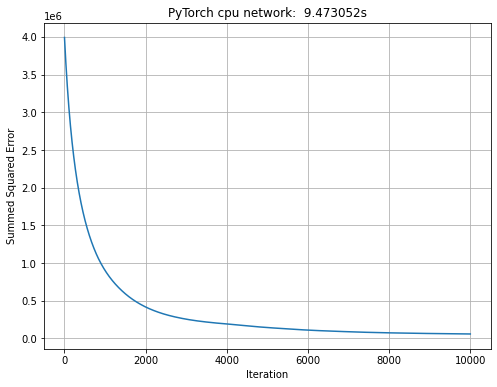

In [33]:
doGPU=False
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
start=time.time()

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, H2, D_out = 64, 2, 16, 16, 1
model = torch.nn.Sequential(torch.nn.Linear(D_in, H1), torch.nn.ReLU(), torch.nn.Linear(H1, H2), torch.nn.ReLU(), torch.nn.Linear(H2, D_out)).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        size = m.weight.size() # returns a tuple
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        m.weight.data = torch.randn(fan_out, fan_in, device=device)

model.apply(weights_init)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function. Setting
# reduction='sum' means that we are computing the *sum* of squared errors rather
# than the mean; this is for consistency with the examples above where we
# manually compute the loss, but in practice it is more common to use mean
# squared error as a loss by setting reduction='elementwise_mean'.
loss_fn = torch.nn.MSELoss(reduction ='sum')

learning_rate = 1e-9
max_iterations = 10000
l2_errors = np.zeros(max_iterations)

for it in range(max_iterations):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(X2)
    
    
    
    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_fn(y_pred, y2)
    l2_errors[it] = loss.item()

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

total_time = time.time()-start
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(l2_errors)
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('PyTorch {0:} network: {1: 0.6f}s'.format(device,total_time))
plt.grid()

In [34]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


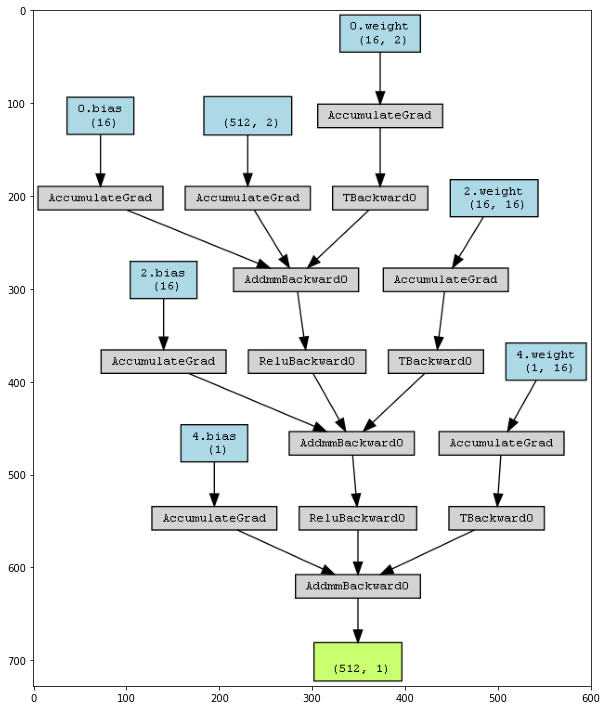

In [35]:
from torchviz import make_dot
import matplotlib.image as mpimg
x = torch.randn(512, 2).requires_grad_(True).to(device)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()))).render("torchviz", format="png")
%matplotlib inline
plt.figure(figsize=(10,20))
img = mpimg.imread('torchviz.png')
plt.imshow(img)
plt.show()

Test the network ten times with ADAM optimizer and ten times with SGD optimizer,
using a suitably high number of iterations.

In [36]:
doGPU=False
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
total_time=np.zeros([10])

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, H2, D_out = 64, 2, 16, 16, 1


max_iterations = 500
l2_errors = np.zeros(max_iterations)

#RUNNING TEN TIMES WITH adam OPTIMIZER
learning_rate = 1e-4

Loss_collection3 =[]
for jj in range(10):
    start=time.time()
    model = torch.nn.Sequential(torch.nn.Linear(D_in, H1), torch.nn.ReLU(), torch.nn.Linear(H1, H2), torch.nn.ReLU(), torch.nn.Linear(H2, D_out)).to(device)

    def weights_init(m):
        if isinstance(m, torch.nn.Linear):
            size = m.weight.size() # returns a tuple
            fan_out = size[0] # number of rows
            fan_in = size[1] # number of columns
            m.weight.data = torch.randn(fan_out, fan_in, device=device)

    model.apply(weights_init)


    loss_fn = torch.nn.MSELoss(reduction ='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for it in range(max_iterations):
        # Forward pass: compute predicted y by passing x to the model.
        y_pred =  model(X2)

        # Compute and print loss.
        loss = loss_fn(y_pred, y2)
        l2_errors[it] = loss.item()

        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward(retain_graph=True)

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    Loss_collection3.append(l2_errors)

    total_time[jj] = time.time()-start


In [37]:
doGPU=False
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
total_time4=np.zeros([10])

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, H2, D_out = 64, 2, 16, 16, 1


max_iterations = 500
l2_errors = np.zeros(max_iterations)

#RUNNING TEN TIMES WITH SGD OPTIMIZER
learning_rate = 1e-4

Loss_collection4 =[]
for jj in range(10):
    start=time.time()
    model = torch.nn.Sequential(torch.nn.Linear(D_in, H1), torch.nn.ReLU(), torch.nn.Linear(H1, H2), torch.nn.ReLU(), torch.nn.Linear(H2, D_out)).to(device)

    def weights_init(m):
        if isinstance(m, torch.nn.Linear):
            size = m.weight.size() # returns a tuple
            fan_out = size[0] # number of rows
            fan_in = size[1] # number of columns
            m.weight.data = torch.randn(fan_out, fan_in, device=device)

    model.apply(weights_init)


    loss_fn = torch.nn.MSELoss(reduction ='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    for it in range(max_iterations):
        # Forward pass: compute predicted y by passing x to the model.
        y_pred =  model(X2)

        # Compute and print loss.
        loss = loss_fn(y_pred, y2)
        l2_errors[it] = loss.item()

        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward(retain_graph=True)

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    Loss_collection4.append(l2_errors)

    total_time4[jj] = time.time()-start

In [ ]:

plt.figure(figsize=(10,10))
plt.plot( Loss_collection[0], 'b',Loss_collection2[0], 'b--', Loss_collection[1], 'g',Loss_collection2[1], 'g--', Loss_collection[2], 'k',Loss_collection2[2], 'k--', Loss_collection[3], 'y',Loss_collection2[3], 'y--', Loss_collection[4], 'r',Loss_collection2[4], 'r--', Loss_collection[5], 'c',Loss_collection2[5], 'c--', Loss_collection[6], 'm',Loss_collection2[6], 'm--')

#plt.plot(Loss_collection2[0], 'g-')
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.legend(['Loss@runtime1- 2Layer', 'Loss@runtime1- 3Layer', 'Loss@runtime2- 2Layer', 'Loss@runtime2- 3Layer', 'Loss@runtime3- 2Layer', 'Loss@runtime3- 3Layer', 'Loss@runtime4- 2Layer', 'Loss@runtime4- 3Layer', 'Loss@runtime5- 2Layer', 'Loss@runtime5- 3Layer', 'Loss@runtime6- 2Layer', 'Loss@runtime6- 3Layer', 'Loss@runtime7- 2Layer', 'Loss@runtime7- 3Layer'])

plt.grid()
plt.show()

<IPython.core.display.Javascript object>


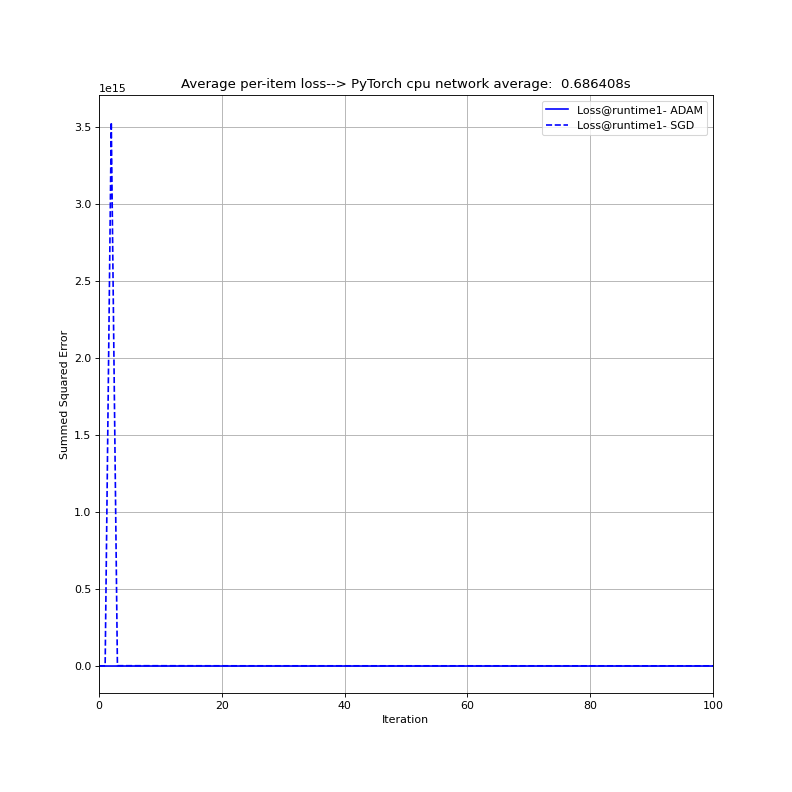

In [51]:
%matplotlib notebook
fig,ax = plt.subplots(figsize=(10,10))
plt.plot( Loss_collection3[0], 'b',Loss_collection4[0], 'b--')

plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('Average per-item loss--> PyTorch {0:} network average: {1: 0.6f}s'.format(device,np.sum(total_time)/10))
plt.legend(['Loss@runtime1- ADAM', 'Loss@runtime1- SGD', 'Loss@runtime2- ADAM', 'Loss@runtime2- SGD', 'Loss@runtime3- ADAM', 'Loss@runtime3- SGD', 'Loss@runtime4- ADAM', 'Loss@runtime4- SGD', 'Loss@runtime5- ADAM', 'Loss@runtime5- SGD', 'Loss@runtime6- ADAM', 'Loss@runtime6- SGD', 'Loss@runtime7- ADAM', 'Loss@runtime7- SGD'])


plt.xlim([0, 100])
plt.grid()

<IPython.core.display.Javascript object>


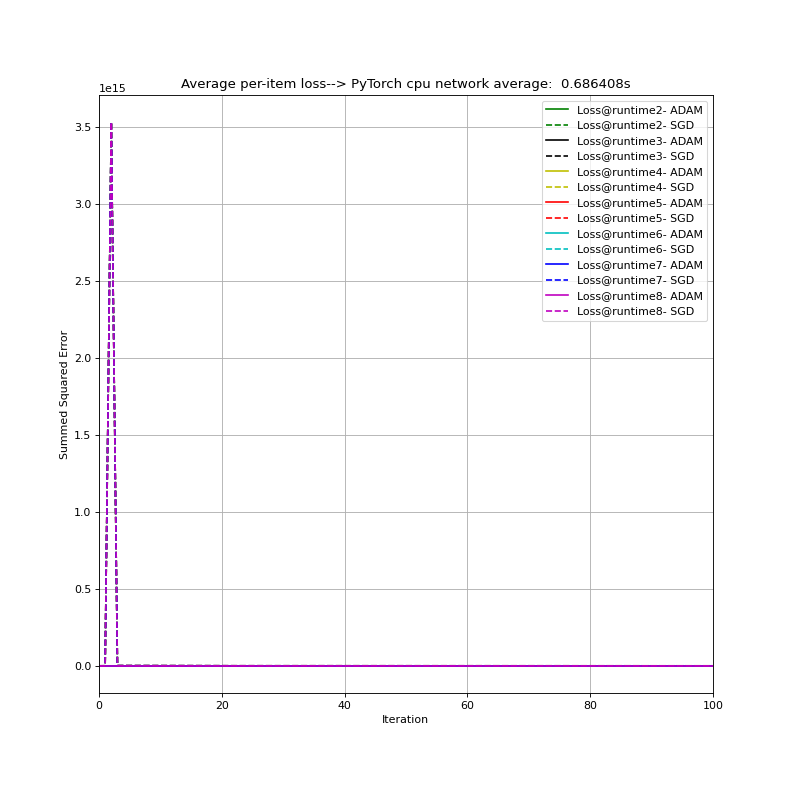

In [54]:
%matplotlib notebook
fig,ax = plt.subplots(figsize=(10,10))
plt.plot( Loss_collection3[1], 'g',Loss_collection4[1], 'g--', Loss_collection3[2], 'k',Loss_collection4[2], 'k--', Loss_collection3[3], 'y',Loss_collection4[3], 'y--', Loss_collection3[4], 'r',Loss_collection4[4], 'r--', Loss_collection3[5], 'c',Loss_collection4[5], 'c--', Loss_collection3[6], 'b',Loss_collection4[6], 'b--', Loss_collection3[1], 'm',Loss_collection4[1], 'm--')

plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('Average per-item loss--> PyTorch {0:} network average: {1: 0.6f}s'.format(device,np.sum(total_time)/10))
plt.legend([ 'Loss@runtime2- ADAM', 'Loss@runtime2- SGD', 'Loss@runtime3- ADAM', 'Loss@runtime3- SGD', 'Loss@runtime4- ADAM', 'Loss@runtime4- SGD', 'Loss@runtime5- ADAM', 'Loss@runtime5- SGD', 'Loss@runtime6- ADAM', 'Loss@runtime6- SGD', 'Loss@runtime7- ADAM', 'Loss@runtime7- SGD', 'Loss@runtime8- ADAM', 'Loss@runtime8- SGD'])


plt.xlim([0, 100])
plt.grid()

we can observe that the ADAM optimizer results in a spike in the losses at the start of the running epoch for each run time while we dontg observe such behaviour with the SGD optimizer 

<IPython.core.display.Javascript object>


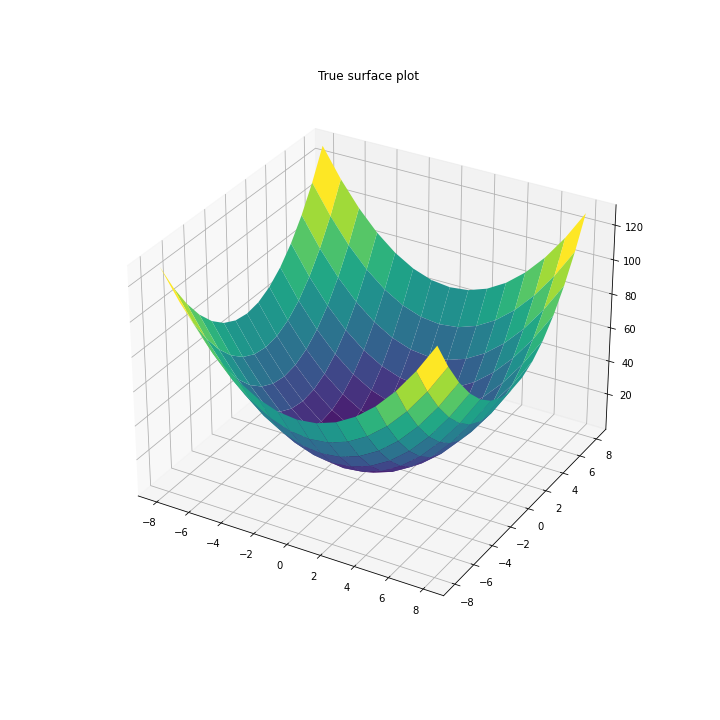

<IPython.core.display.Javascript object>


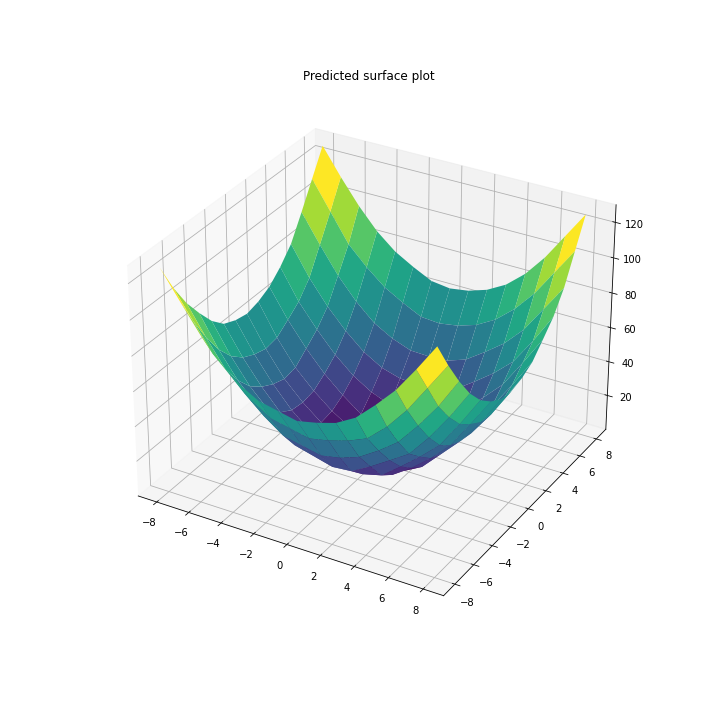

In [17]:
# plot data
[xsm,ysm]=np.meshgrid(xs,ys)
target = np.zeros((numDataOne,numDataOne))
for i,x in enumerate(xs):
    for j,y in enumerate(ys):
        target[i,j]=x**2+y**2+1.  #we can try and see how well the function does for different target functions

%matplotlib notebook
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xsm, ysm, target,cmap='viridis', edgecolor='none')
ax.set_title('True surface plot')
plt.show()

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xsm, ysm, np.reshape(output[4],(numDataOne,numDataOne)),cmap='viridis', edgecolor='none')
ax.set_title('Predicted surface plot')
plt.show()

In [ ]:
 for j in range(L-1):
        A_previous = A
    
        Z[j] = np.dot(W[j], A) + b[j]  # vectorized version

        A = model['activation_function'][Z[j]]
        
     
    Z[L-1] = np.dot(W[L-1], ) + b[L-1]
    
    
    # no activation function as this is simply a linear layer!!
    out = Z[L-1] 